In [1]:
import torch
import torch.nn as nn
import os
from torch import optim
from model import VisionTransformer6
from utils_vit import get_loader
from tqdm import tqdm
import contextlib
import datetime

In [2]:
device = torch.device("mps")

train_loader, test_loader = get_loader()
model = VisionTransformer6().to(device)
ce = nn.CrossEntropyLoss()
    
def train_and_evaluate():
    optimizer = optim.AdamW(model.parameters(), 5e-4, weight_decay=1e-3)
    cos_decay = optim.lr_scheduler.CosineAnnealingLR(optimizer, 200, verbose=True)
    total_step = len(train_loader)

    accuracies = []

    for epoch in range(200):
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        model.train()
        for i, (images, labels) in pbar:
            with contextlib.redirect_stdout(open(os.devnull, "w")):
                optimizer.zero_grad()
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = ce(outputs, labels)
                loss.backward()
                optimizer.step()
                if (i + 1) % 200 == 0:
                    pbar.set_description(f'Epoch [{epoch + 1}/{200}], Step [{i + 1}/{total_step}], Loss: {loss.item()}')
                cos_decay.step()

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            pbar_test = tqdm(test_loader)
            for images, labels in pbar_test:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pbar_test.set_description(f'Accuracy: {100 * correct / total:.2f}%')

            accuracy = 100 * correct / total
            accuracies.append(accuracy)
    return accuracies

In [3]:
start_time = datetime.datetime.now()
accuracies = train_and_evaluate()
end_time = datetime.datetime.now()

best_accuracy = max(accuracies)
print(f'Final accuracy: {best_accuracy:.2f}%')
print(f'Training time: {end_time - start_time}')

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch [1/200], Step [400/468], Loss: 0.8519952297210693: 100%|██████████| 468/468 [00:45<00:00, 10.36it/s]
Accuracy: 70.06%: 100%|██████████| 79/79 [00:05<00:00, 15.32it/s]
Epoch [2/200], Step [400/468], Loss: 0.7598881721496582: 100%|██████████| 468/468 [00:46<00:00, 10.13it/s]
Accuracy: 74.49%: 100%|██████████| 79/79 [00:05<00:00, 14.58it/s]
Epoch [3/200], Step [400/468], Loss: 0.5056130886077881: 100%|██████████| 468/468 [00:47<00:00,  9.83it/s]
Accuracy: 78.02%: 100%|██████████| 79/79 [00:05<00:00, 14.99it/s]
Epoch [4/200], Step [400/468], Loss: 0.6337413787841797: 100%|██████████| 468/468 [00:47<00:00,  9.84it/s]
Accuracy: 79.19%: 100%|██████████| 79/79 [00:05<00:00, 14.86it/s]
Epoch [5/200], Step [400/468], Loss: 0.48999524116516113: 100%|██████████| 468/468 [00:47<00:00,  9.79it/s]
Accuracy: 78.76%: 100%|██████████| 79/79 [00:05<00:00, 14.73it/s]
Epoch [6/200], Step [400/468], Loss: 0.5943498611450195: 100%|██████████| 468/468 [00:49<00:00,  9.54it/s]
Accuracy: 79.73%: 100%|████

Final accuracy: 92.30%
Training time: 3:12:07.490904


[70.06, 74.49, 78.02, 79.19, 78.76, 79.73, 80.47, 83.06, 83.51, 83.6, 83.62, 83.0, 84.48, 85.45, 85.75, 85.12, 85.15, 85.26, 86.13, 86.96, 87.21, 87.46, 86.06, 84.81, 86.71, 87.72, 88.02, 88.06, 87.22, 86.52, 87.59, 88.52, 88.57, 88.56, 87.48, 87.46, 87.7, 88.88, 88.69, 88.3, 87.6, 87.43, 88.47, 89.13, 89.53, 88.86, 86.95, 88.29, 89.39, 89.72, 89.5, 88.76, 88.63, 87.97, 89.61, 89.89, 89.73, 89.37, 88.95, 88.42, 90.19, 89.82, 90.02, 90.06, 89.31, 89.33, 90.15, 90.4, 90.36, 89.87, 89.01, 89.9, 90.38, 90.44, 90.65, 89.42, 89.32, 90.34, 90.59, 90.65, 90.51, 89.53, 90.03, 90.45, 91.04, 91.14, 90.67, 90.39, 90.18, 90.71, 91.19, 90.99, 90.61, 90.36, 89.96, 90.81, 90.79, 91.21, 90.88, 89.97, 90.63, 91.23, 91.43, 91.29, 91.0, 90.6, 90.85, 90.94, 91.54, 91.27, 90.34, 90.65, 90.76, 91.76, 91.71, 91.67, 91.59, 90.65, 90.83, 91.59, 91.79, 91.83, 90.88, 90.64, 91.19, 91.77, 92.02, 91.74, 91.33, 91.11, 91.85, 91.61, 91.78, 91.44, 91.14, 91.23, 91.27, 92.06, 91.92, 91.81, 91.33, 91.68, 91.93, 91.71, 9

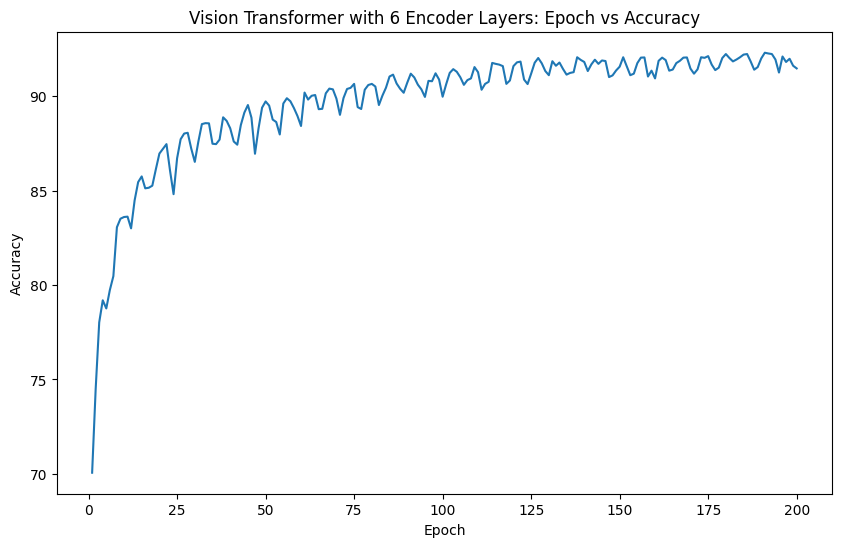

In [5]:
from matplotlib import pyplot as plt

print(accuracies)
epochs = list(range(1, len(accuracies) + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, linestyle='-')
plt.title('Vision Transformer with 6 Encoder Layers: Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()